## isolate AMR analysis - acquired genes counting

this analysis uses
* srst2: https://github.com/katholt/srst2
* prokka: https://github.com/tseemann/prokka

In [1]:
import sys,os,subprocess,glob
%matplotlib inline
import pylab as plt
import pandas as pd
import numpy as np
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import seaborn as sns
sns.set_context("talk")
plt.rcParams["figure.dpi"] = 90
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
spectral = sns.color_palette("Spectral", 3)
from IPython.display import display, HTML
clrs = ["#007acc", "#2ecc71", "#e74c3c"]
my_cmap = ListedColormap(sns.color_palette(clrs).as_hex())
from epitopepredict import sequtils
pd.set_option('display.width', 130)
pd.set_option('display.max_colwidth', 120)
from tools import *

In [15]:
path = 'scaffolds'
info = pd.read_csv('isolates.csv')
names = info.id
isolates = list(info[info.stage!='reference'].id)[:-1]

acinet = ['RF14B','RF15A','RF15B']#,'909D3A']
refs = ['ecoli_k12','ecoli_IAI39','ecoli_UMN026','ecoli_O157_str.Sakai'] #'ecoli_O104_str.2011C-3493'
acinrefs=['Acin_lwof_NCTC5866','Acin_lwof_ZS207','Acin_schi_str_ACE','Acin_sp_ACNIH1','Acin_sp_LoGeW2-3']
ecoli = list(names[-names.isin(acinet)])[:-3]
pen = ['RF14B', 'RF15A', 'RF15B', 'RF14A','RF16A', 'ecoli_k12', 'Acin_lwof_NCTC5866']
print ecoli[:-10]
pig = ecoli[:-10] + acinet 
dog = ['9805','9808']

info['stage'] = info.stage.astype('category')


['RF1A', 'RF2A', 'RF2B', 'RF2C', 'RF5A', 'RF6A1', 'RF6A2', 'RF6B', 'RF6C', 'RF7A', 'RF8A', 'RF8B', 'RF9', 'RF11', 'RF12A', 'RF14A', 'RF16A']


In [3]:
#stage color mapping for clustermap
stage = info[:20].set_index('id').stage
pal =sns.color_palette('hls', len(stage.unique()))
lut = dict(zip(stage.unique(), pal))
print lut
row_colors = stage.map(lut)
#print row_colors

{'farrowing': (0.86, 0.3712, 0.33999999999999997), 'hospital pen': (0.6311999999999998, 0.33999999999999997, 0.86), '1st stage weaner': (0.5688000000000001, 0.86, 0.33999999999999997), '2nd stage weaner': (0.33999999999999997, 0.8287999999999999, 0.86)}


### kmerfinder for ecoli ID

In [ ]:
def kmerfinder(name):
    f = 'contigs/%s.fa' %name    
    cmd = 'findTemplate -i %s -t kmerfinder_db/bacteria.organisms.ATGAC -o temp.tab -w' %(f)
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab', sep='\t')
    return df

K=[]
for n in ecoli[:-5]:
    df=kmerfinder(n)
    df.insert(0,'name',n)
    K.append(df)
K=pd.concat(K)
K = K.sort_values(['name','Score'], ascending=False).drop_duplicates(['name'])
K.to_csv('species_kmerfinder.csv',index=False)
#K.iloc[K.groupby('name')['Score'].idxmax().values]

### acquired genes using abricate (assembly-blast method)

In [235]:
adbs = ['card']#,'vfdb','resfinder','plasmidfinder','argannot']
db = 'vfdb'
db='resfinder'
#db='plasmidfinder'
#db = 'argannot'

def abricate(name, db='card',path='scaffolds'):
    cmd = '/local/abricate/bin/abricate %s/%s.fa -db %s --mincov 50 --minid 90 > temp.tab' %(path,name,db)
    print cmd
    subprocess.check_output(cmd, shell=True, executable='/bin/bash')
    df = pd.read_csv('temp.tab',sep='\t')
    df['id'] = name
    return df

cols=['id','GENE','%IDENTITY']

#adbs=['plasmidfinder']
abr=[]
for db in adbs:
    print db
    res = []
    for n in ['ecoli_k12']:
        df = abricate(n,db,path='genomes')
        res.append(df)
    for n in pig:
        print n
        df = abricate(n,db,path='scaffolds')
        res.append(df)

    res = pd.concat(res)
    #remove duplicates
    res = res.sort_values(['#FILE','SEQUENCE','%IDENTITY'])
    #res = res.drop_duplicates(['SEQUENCE','START'])
    res.to_csv('abr_%s.csv' %db,index=False)
    abr.append(res)
    
abr=pd.concat(abr)
#abr.to_csv('abr_all.csv',index=False)

card
/local/abricate/bin/abricate genomes/ecoli_k12.fa -db card --mincov 50 --minid 90 > temp.tab
RF1A
/local/abricate/bin/abricate scaffolds/RF1A.fa -db card --mincov 50 --minid 90 > temp.tab
RF2A
/local/abricate/bin/abricate scaffolds/RF2A.fa -db card --mincov 50 --minid 90 > temp.tab
RF2B
/local/abricate/bin/abricate scaffolds/RF2B.fa -db card --mincov 50 --minid 90 > temp.tab
RF2C
/local/abricate/bin/abricate scaffolds/RF2C.fa -db card --mincov 50 --minid 90 > temp.tab
RF5A
/local/abricate/bin/abricate scaffolds/RF5A.fa -db card --mincov 50 --minid 90 > temp.tab
RF6A1
/local/abricate/bin/abricate scaffolds/RF6A1.fa -db card --mincov 50 --minid 90 > temp.tab
RF6A2
/local/abricate/bin/abricate scaffolds/RF6A2.fa -db card --mincov 50 --minid 90 > temp.tab
RF6B
/local/abricate/bin/abricate scaffolds/RF6B.fa -db card --mincov 50 --minid 90 > temp.tab
RF6C
/local/abricate/bin/abricate scaffolds/RF6C.fa -db card --mincov 50 --minid 90 > temp.tab
RF7A
/local/abricate/bin/abricate scaffolds

In [236]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x
    
def read_abr(fname):
    label='GENE'
    res = pd.read_csv(fname)
    if len(res)==0: return
    #res = res.drop_duplicates(['id','SEQUENCE','START'])    
    m = pd.pivot_table(res, index='id', columns=label, values='PRODUCT', aggfunc=np.size)  
    return m
    
def plot_heatmap(x,title='',merge=True,cluster=False,cmap=my_cmap,ax=None):
    sns.set(font_scale=1.2)    
    w=len(x.T)/5+5
    f=None
    if cluster == False:
        if merge==True:
            x = merge_info(x)
            #x.sort_index(level=0, inplace=True)
        if ax==None:
            f,ax=plt.subplots(figsize=(w,8))
        sns.heatmap(x,cmap=cmap,xticklabels=1,linewidths=.5,
                    linecolor='gray',cbar=False,ax=ax)
        #ax.set_title(title)
        
        return f
    else:      
        x=x.fillna(0)
        #x=x.index.droplevel(1)   
        cg = sns.clustermap(x,cmap=cmap,linewidths=.5,xticklabels=1,figsize=(w,8),
                            row_colors=row_colors)
        ax=cg.ax_heatmap
        cg.cax.set_visible(False)
        leg = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
        cg.ax_heatmap.legend(handles=leg,loc='upper center', bbox_to_anchor=(0.3, .98), ncol=2,
                             bbox_transform=plt.gcf().transFigure,frameon=True)
        cg.fig.subplots_adjust(top=.9,bottom=.2)
        return cg.fig

card


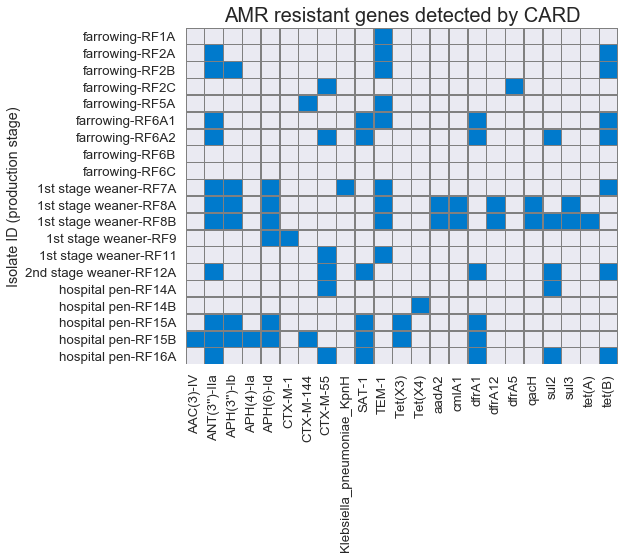

In [240]:
abr=[]

for db in ['card']:
    print db
    f = 'abr_%s.csv' %db
    x = read_abr(f)    
    x = x.clip(0,1)
    #print (x)
    #remove genes present in K12
    if 'ecoli_k12' in x.index:
        x = x[x.columns[x.loc['ecoli_k12'].isnull()]]   
        x = x.drop(('ecoli_k12'))
    x = x.dropna(1,'all')
    x = x.sort_index()

    #try:    
    #    x = x.drop(['TEM-33','tet(D)','CTX-M-33'],1)
    #except:
    #    pass   

    f=plot_heatmap(x,db)#,cmap='Blues',cluster=True)
    ax=f.gca()
    ax.set_title('AMR resistant genes detected by %s' %db.upper(),fontsize=20)
    ax.set_ylabel('Isolate ID (production stage)')
    plt.tight_layout()    
    f.savefig('abr_%s_genes.png' %db,dpi=150)
    #x.index=x.index.droplevel(1)
    x.to_csv('abr_%s_counts.csv' %db)
    #print list(x.columns)

In [ ]:
#db='plasmidfinder'
db='card'
x = pd.read_csv('abr_%s.csv' %db)
print len(x)
x = x.sort_values(['#FILE','SEQUENCE','%IDENTITY'])
x=x.drop_duplicates(['SEQUENCE','START'])
print x
#x['LOCI'] = x.groupby(['SEQUENCE','#FILE'])['GENE'].transform('count')
#x.set_index(['SEQUENCE','#FILE'])


### get abr gene alignments with the contigs they are found in each sample

In [392]:
cardseqs = SeqIO.to_dict(SeqIO.parse('card_abr.fa','fasta'))
res = pd.read_csv('abr_card.csv')
#print res[:3]
#get abr gene seq alignments
genes = ['CTX-M-55','TEM-4','tetX','CTX-M-1','SAT-1','CTX-M-144']

def maaft_alignment(seqfile):
    out = os.path.splitext(seqfile)[0]+'.aln'
    cmd = 'mafft --auto --adjustdirection %s > %s' %(seqfile,out)
    #print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

def extract_hits(res, genes=[], key='GENE'):
    #get hit sequences from contigs
    for g in genes:
        x = res[res[key]==g]
        #print g, x
        found=[]
        for i,r in x.iterrows():
            name=r.id
            if name not in isolates: continue
            seqs = SeqIO.to_dict(SeqIO.parse('scaffolds/%s.fa' %r.id,'fasta'))
            node = r.SEQUENCE        
            s = seqs[node].seq[r.START:r.END]
            s = SeqRecord(id=name,seq=s)
            found.append(s)
            print name, r.GENE, r['%COVERAGE'], r['%IDENTITY'], len(s), node
            #add card seq
        found.append(cardseqs[r.GENE])
        #print len(cardseqs[r.GENE])
        seqfile = 'card_%s.fa' %g
        SeqIO.write(found,seqfile,'fasta')
        maaft_alignment(seqfile)
        
extract_hits(res, genes)     

RF11 CTX-M-55 100.0 100.0 875 NODE_97_length_17434_cov_77.1174
RF12A CTX-M-55 100.0 100.0 875 NODE_101_length_17482_cov_62.551
RF14A CTX-M-55 100.0 100.0 875 NODE_54_length_32372_cov_153.678
RF16A CTX-M-55 100.0 100.0 875 NODE_98_length_17391_cov_134.048
RF2C CTX-M-55 100.0 100.0 875 NODE_33_length_28043_cov_92.141
RF6A2 CTX-M-55 100.0 100.0 875 NODE_94_length_17482_cov_63.5478
RF9 CTX-M-1 52.85 100.0 462 NODE_89_length_10487_cov_92.3782
RF12A SAT-1 100.0 100.0 524 NODE_157_length_6836_cov_70.883
RF15A SAT-1 100.0 100.0 524 NODE_26_length_38011_cov_86.3981
RF15B SAT-1 100.0 100.0 524 NODE_25_length_25084_cov_86.3603
RF16A SAT-1 100.0 100.0 524 NODE_105_length_16198_cov_135.908
RF6A1 SAT-1 100.0 100.0 524 NODE_11_length_50376_cov_59.17
RF6A2 SAT-1 100.0 100.0 524 NODE_138_length_6836_cov_67.0704
RF15B CTX-M-144 54.34 100.0 475 NODE_115_length_476_cov_0.991404
RF5A CTX-M-144 52.17 100.0 456 NODE_68_length_9026_cov_89.4225


In [ ]:
#dog
db='card'   
f = 'abr_%s.csv' %db
x = read_abr(f)
x = x.sort_index()
x = x.loc[dog+['ecoli_k12']]
#print x
x = x.dropna(1,'all')    
f=plot_heatmap(x,db)
f.gca().set_title('%s genes present in dog isolates' %db)
plt.tight_layout()
f.savefig('abr_dog_%s_genes.png' %db)

### serotypefinder

In [6]:
for n in ecoli:
    cmd = 'perl serotypefinder/serotypefinder.pl -d serotypefinder/database -i scaffolds/{n}.fa -s ecoli -k 80 -l .60 -o serotype_results_old/{n}'.format(n=n)
    #print cmd
    subprocess.check_output(cmd,shell=True)
    
def get_sero_results(path):
    res=[]
    cols=['gene', 'perc_ident','Identity','contig','position','hit','accession']
    for n in ecoli[:19]:
        df = pd.read_csv('%s/%s/results_tab.txt' %(path,n), sep='\t',names=cols,skiprows=1)
        df['id']=n
        res.append(df)
        #print df
    res=pd.concat(res)
    #print res[:2]
    x = pd.pivot_table(res, index='id',values='hit',columns='gene',aggfunc='first')
    x.to_csv('ecoli_serotypefinder.csv')
    print x
    
get_sero_results('serotype_results')


gene  fliC   wzm   wzt   wzx   wzy
id                                
9805    H8  None  None  O116  None
9808    H1  None  None    O6    O6
RF11    H9  None  None  O174  O174
RF12A   H2  None  None  O103  O103
RF14A  H18    O9    O9  None  None
RF16A   H2  None  None  O103  O103
RF1A   H10  None    O8  None  None
RF2A    H9    O8    O8    O8    O8
RF2B    H9    O8    O8    O8    O8
RF2C   H17    O8    O8  None  None
RF5A    H9  None  None  O174  O174
RF6A1  H21  None  None   O88   O88
RF6A2   H2  None  None  O103  O103
RF6B   H12  None  None   O26   O26
RF6C   H21  None  None  O155  None
RF7A    H9    O8    O8    O8    O8
RF8A   H10  None  None   O64   O64
RF8B   H10  None  None   O64   O64
RF9    H12  None  None  None  None


### mlst with CBS software

In [ ]:
def MLST(name, db='ecoli'):
    cmd = 'perl MLST/mlst.pl -i scaffolds/%s.fa -d MLST/database -o mlst_results/%s -s %s' %(name,name,db)
    print cmd
    f = 'mlst/%s' %name
    if not os.path.exists(f):
        subprocess.check_output(cmd, shell=True, executable='/bin/bash')  

for n in ecoli:
    MLST(n)

In [126]:
def read_mlst_res(f):
    f=open(p,'r')
    s=f.readline().split(':')[1].strip()    
    f.readline()
    x=[f.readline().strip('\n').split('\t')[5] for i in range(7)]
    st = '_'.join(x)
    return st,s

#read mlst
res=[]
new={}
c=1
for n in ecoli: 
    p=os.path.join('mlst_results/%s' %n, 'results_tab.txt')
    if not os.path.exists(p): continue
    st,s=read_mlst_res(f)   
    
    if s == 'Unknown ST':        
        if not st in new:
            s = 'newST%s' %c
            new[st] = s
            c+=1
        else:
            s = new[st]    
    #print s,st
    #print new      
    res.append((n,s,st))

res=pd.DataFrame(res,columns=['name','ST','genes'])
#print info
#res = res.merge(info,left_on='name',right_on='id')
res.to_csv('results_MLST.csv')
print res

      name      ST                                                        genes
0     RF1A  newST1       adk-1_fumc-798_gyrb-470_icd-16_mdh-175_pura-434_reca-1
1     RF2A  newST2          adk-6_fumc-798_gyrb-12_icd-1_mdh-20_pura-379_reca-1
2     RF2B  newST3             adk-6_fumc-4_gyrb-12_icd-1_mdh-20_pura-13_reca-1
3     RF2C    ST58             adk-6_fumc-4_gyrb-4_icd-16_mdh-24_pura-8_reca-14
4     RF5A  newST4        adk-100_fumc-798_gyrb-470_icd-8_mdh-7_pura-163_reca-1
5    RF6A1   ST101           adk-43_fumc-41_gyrb-15_icd-18_mdh-11_pura-7_reca-6
6    RF6A2    ST17               adk-6_fumc-4_gyrb-3_icd-17_mdh-7_pura-7_reca-6
7     RF6B    ST48               adk-6_fumc-11_gyrb-4_icd-8_mdh-8_pura-8_reca-2
8     RF6C  newST5      adk-6_fumc-798_gyrb-470_icd-16_mdh-175_pura-434_reca-10
9     RF7A  newST6            adk-6_fumc-4_gyrb-12_icd-1_mdh-20_pura-13_reca-14
10    RF8A   ST424            adk-6_fumc-30_gyrb-32_icd-16_mdh-11_pura-8_reca-7
11    RF8B   ST424            adk-6_fumc

### virulence genes

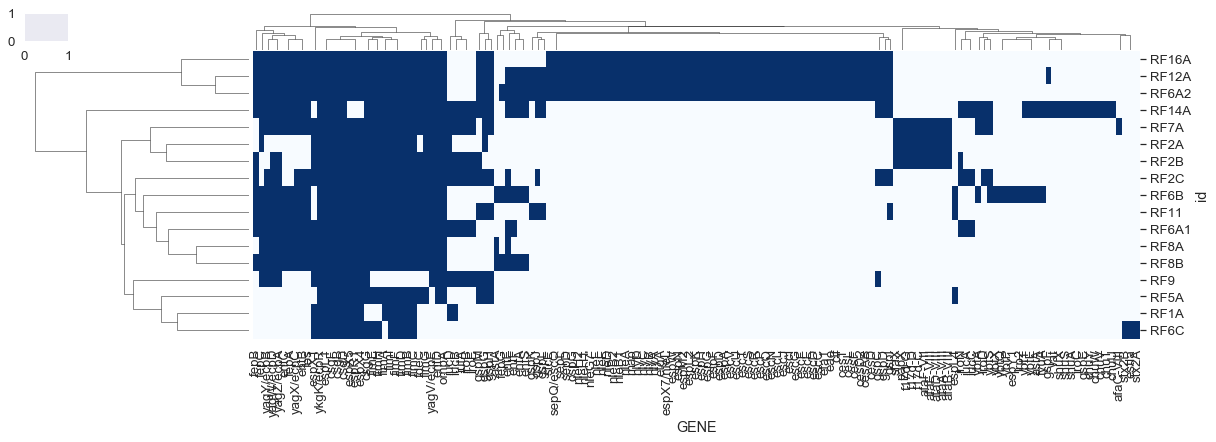

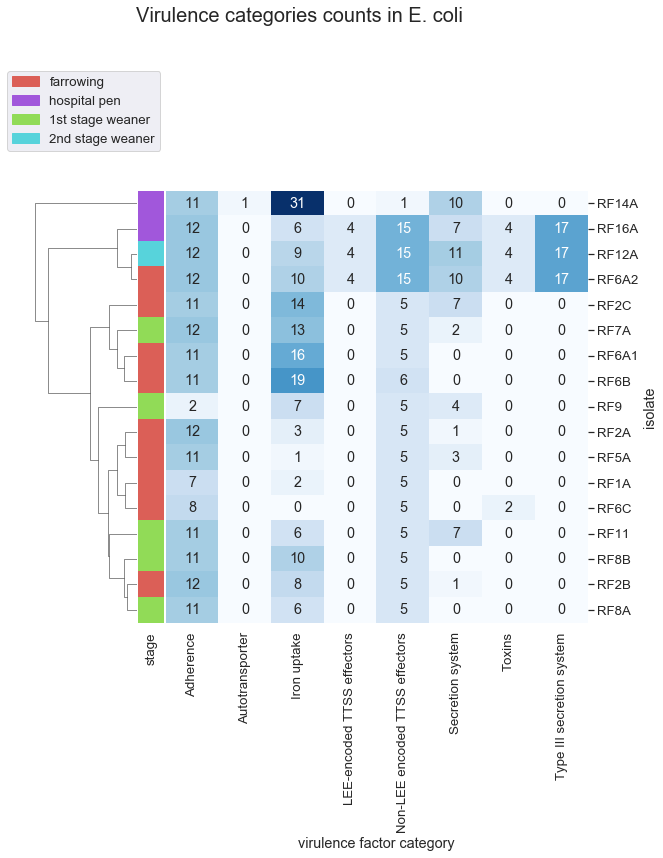

In [72]:
omit=['9808','9805']
vf=pd.read_csv('VF_table.csv')
vf=vf[vf.columns[:3]]
#merge vf table with classes
x = pd.read_csv('abr_vfdb.csv')
x = x[-x.id.isin(omit)]
x = x.merge(vf, left_on='GENE',right_on='Related genes',how='left')
x = x.drop_duplicates(subset=['id','GENE'])
x['gene_group'] = x.GENE.str[:3]
x.to_csv('results_virulence.csv',index=False)
x = x[x.id.isin(pig)]

m = pd.pivot_table(x, index=['id'], columns='GENE', values='PRODUCT', aggfunc=np.size)#.T
#print (m)
#m = m.loc[ecoli]
m = m.T

#m = m[m.ecoli_k12.isnull()]
found = list(m.index)

m=m.fillna(0)
#m = m.reset_index().merge(vf, left_on='GENE',right_on='Related genes',how='left')
#m = m.set_index(['GENE','VFclass'])[pig]
cg=sns.clustermap(m.T,xticklabels=1,yticklabels=1,cbar=False,cmap='Blues',figsize=(20,6),)
cg.savefig('virulence_factors_presence.png')

#print (m)

g=x.groupby(['id','VFclass']).agg({'GENE':np.size})
g=g.unstack()
#print g[:3]
g.columns=g.columns.get_level_values(1)
g.T.to_csv('virulence_factors_counts.csv')

cg=sns.clustermap(g.fillna(0),cmap='Blues',annot=True,row_colors=row_colors,col_cluster=False,)
cg.cax.set_visible(False)
ax=cg.ax_heatmap
leg = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
ax.legend(handles=leg,loc='upper center', bbox_to_anchor=(0.2, .9),
                     bbox_transform=plt.gcf().transFigure,frameon=True)
ax.set_xlabel('virulence factor category')
ax.set_ylabel('isolate')
cg.fig.suptitle('Virulence categories counts in E. coli',fontsize=20)
cg.savefig('virulence_factors_counts.png')

g = x.groupby(['id','VFclass']).apply(lambda x: ','.join(list(x.GENE)))
g.to_csv('virulence_gene_lists.csv')
#print g.unstack(1)


In [ ]:
group2=['Autotransporter','Host immune evasion',
        'Regulation','Stress adaptation','LEE-encoded TTSS effectors']
group1 = list(ind[~ind.isin(group2)])
print group1

In [57]:
#x = x[x.VFclass!='Other']
v = x.groupby(['id','VFclass','gene_group']).agg({'PRODUCT':np.size})
v = v.unstack(0)
v.columns=v.columns.get_level_values(1)
#print v
v.to_csv('virulence_by_factor.csv')

#v = v[v.ecoli_k12.isnull()]
#v = v.dropna(1,'all')
#v.columns = v.columns.map(lambda x: x[:14])
#ind = v.index.get_level_values(0).unique()


In [ ]:
#print g
f,ax=plt.subplots(1,1,figsize=(10,10))
sns.heatmap(v,xticklabels=1,yticklabels=1,ax=ax,cbar=False,cmap=my_cmap)
plt.tight_layout()
plt.savefig('virulence_by_factor_heatmap.png')
x=v.fillna(0)
#x.index=x.index.droplevel(0)
cg=sns.clustermap(x,cmap='Blues',xticklabels=1,yticklabels=1,col_colors=row_colors,row_cluster=False,figsize=(10,12))
leg = [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
cg.ax_heatmap.legend(handles=leg,loc='upper center', bbox_to_anchor=(0.8, .95),
                     bbox_transform=plt.gcf().transFigure,frameon=True)
cg.cax.set_visible(False)
cg.fig.subplots_adjust(top=.9,left=.03,right=.7)
plt.savefig('virulence_by_factor_clustermap.png')

### get plasmid contigs from abr results

In [73]:
plas = pd.read_csv('abr_plasmidfinder.csv')
#print plas.columns
plas.drop('GENE',1)
plas = plas.rename(columns={'PRODUCT':'REPLICON'})
plas['LENGTH'] = plas.END-plas.START
#print plas
#merge with hits in abr
abr = pd.read_csv('abr_all.csv')
abr = abr[abr.DATABASE!='plasmidfinder']

cols = ['id','SEQUENCE','REPLICON','GENE']
x = abr.merge(plas[cols[:3]],on=['id','SEQUENCE'])
x = x.groupby(cols[:3]).apply(lambda x: list(x.GENE)).reset_index().rename(columns={0:'GENE'})
display(x)
x.to_csv('plasmids_abr_genes.csv',index=False)

,id,SEQUENCE,REPLICON,GENE
0,RF11,NODE_97_length_17434_cov_77.1174,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
1,RF12A,NODE_101_length_17482_cov_62.551,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
2,RF14A,NODE_54_length_32372_cov_153.678,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
3,RF16A,NODE_98_length_17391_cov_134.048,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
4,RF2C,NODE_26_length_30377_cov_96.2722,plasmidfinder~~~IncFIB(AP001918)_1~~~AP001918 IncFIB(AP001918)_1__AP001918,[iroB]
5,RF2C,NODE_33_length_28043_cov_92.141,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
6,RF5A,NODE_131_length_6706_cov_65.3525,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,[eptA]
7,RF6A1,NODE_121_length_12950_cov_64.8673,plasmidfinder~~~IncFIC(FII)_1~~~AP001918 IncFIC(FII)_1__AP001918,"[TEM-1, blaTEM-1B_1, (Bla)blaTEM-105]"
8,RF6A2,NODE_94_length_17482_cov_63.5478,plasmidfinder~~~IncI1_1_Alpha~~~AP005147 IncI1_1_Alpha_AP005147,"[CTX-M-55, blaCTX-M-55_1, (Bla)blaCTX-M-55]"
9,RF7A,NODE_78_length_14752_cov_56.4466,plasmidfinder~~~IncFIC(FII)_1~~~AP001918 IncFIC(FII)_1__AP001918,"[APH(6)-Id, APH(3'')-Ib, aph(6)-Id_1, aph(3'')-Ib_2, (AGly)strB, (AGly)strA]"


### PMLST with CBS 

In [ ]:
def PMLST(name, db='incf'):    
    cmd = 'perl PMLST/pmlst.pl -i scaffolds/{n}.fa -d PMLST/database -o pmlst_{db}/{n} -s {db}'.format(n=name,db=db)
    
    print cmd
    f = 'pmlst_%s/%s' %(db,name)
    if not os.path.exists(f):
        subprocess.check_output(cmd, shell=True, executable='/bin/bash')  

plasmidsp=['incf','incn','inci1','inchi1','inchi2']
for sp in plasmidsp:
    for n in ecoli[:-6]:
        PMLST(n,sp) 

In [ ]:
sp='inci1'
res=[]
ec=ecoli[:-6]
for sp in plasmidsp:
    print sp
    z=[]
    for n in ec:    
        p=os.path.join('pmlst_%s/%s' %(sp,n), 'results_tab.txt')
        if not os.path.exists(p): 
            z.append(None)
            continue   
        f=open(p,'r')
        s=f.readline().split(' ')[2].strip()    
        #print s     
        z.append(s)
    x=pd.Series(z,index=ec,name=sp)
    res.append(x)
    
res=pd.DataFrame(res)
res=res.T

res = res.merge(info,left_index=True,right_on='id',how='inner').set_index('id')
print res
res.to_csv('results_PMLST.csv')  

### phaster

In [87]:
#phaster results
infile='phaster/9808/detail.txt'
ph = pd.read_csv('phaster/9808/detail.txt',sep='\t',skiprows=5)

import csv
reader = open(infile, 'rb')

sections={}
lbl=None
for row in reader:           
    if row.startswith('##'):
        lbl=row.split(' ')[3]
        sections[lbl]=[]
    elif lbl!=None:
        row=row.split('     ')
        row=filter(len,row)
        #print row
        sections[lbl].append(row)

#print sections
cols = ['location','hit','e-value','prophage_seq']
res=[]
for s in sections:
    #print sections[s][0]
    df=pd.DataFrame(sections[s],columns=cols)
    df=df.apply(lambda x: x.str.strip(),1)
    df['contig'] = s
    #print df[:6]
    res.append(df)
res = pd.concat(res)
res.to_csv('phaster/9808/results.csv',index=False)

### hospital pen plots

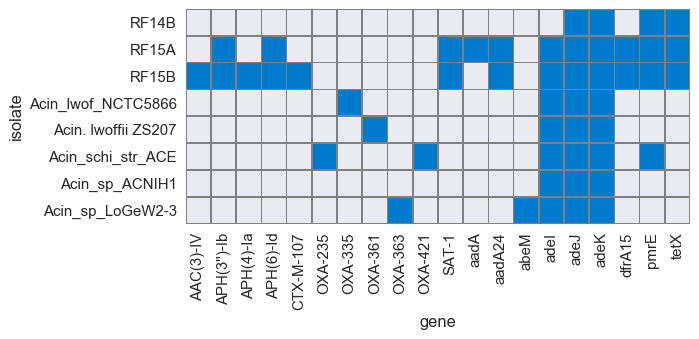

In [18]:
#for paper
db='card'
fn = 'abr_%s.csv' %db 
abr = read_abr(fn)
#print abr
p = acinet+acinrefs
x = abr.loc[p,:]
x.index.name='isolate'
x=x.drop('OXA-97',1)
x = x.dropna(axis=1,how='all')
x=x.rename({'Acin_lwof_refseq':'Acin. lwoffii NCTC 5866','Acin_lwof_ZS207':'Acin. lwoffii ZS207'})
#print x[['OXA-335', u'OXA-361']]
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_heatmap(x,'AMR genes identified by CARD',merge=False,ax=ax,cmap=my_cmap)
ax.set_xlabel('gene')
plt.tight_layout()
f.savefig('hosp_pen_card.png')

In [ ]:
#hospital pen
abr = read_abr(fn,['id','species'])
p  = ['RF14A', 'RF14B', 'RF15A', 'RF15B', 'RF16A']#, 'ecoli_k12','Acin_lwof_refseq']
x = abr.loc[p,:]
x.index=x.index.swaplevel().sort_values()
x=x.T
#x = x[x['ecoli_k12'].isnull()]
x = x.dropna(0,'all')
#x

### pca

6 7


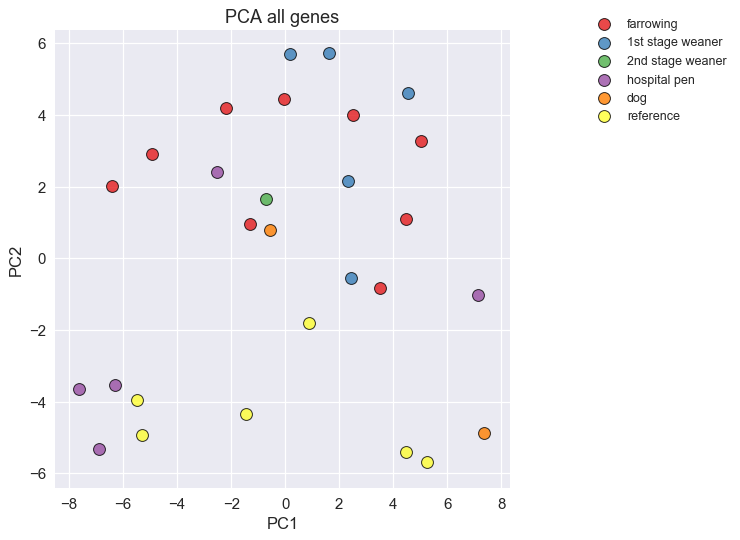

In [157]:
from smallrnaseq import analysis
db='argannot'
db='vfdb'

def pca(db):     
    #X = X.set_index(['id','stage'])
    X = read_abr('abr_%s.csv' %db)    
    X = merge_info(X)
    #X=X.drop(('ecoli_O157_str.Sakai'))
    
    X.index = X.index.get_level_values(0)
    #X = X[X.index.notnull()]
    X = X.notnull().astype('int')
    X = X.fillna(0)
    #print X
    pX = analysis.do_mds(X)
    ax=analysis.plot_pca(pX, palette='Set1')
    plt.title('PCA %s genes' %db)
    
#pca('vfdb')
pca('all')


### integron finder

In [30]:
from Bio import SeqIO

def int_finder(n):
    cmd = 'integron_finder %s --local_max --func_annot --outdir int_finder' %n
    #print cmd
    temp = subprocess.check_output(cmd, shell=True)
    f='int_finder/Results_Integron_Finder_temp/temp.integrons'    
    l = open(f,'r').readlines()
    return l

for name in acinet:
    print name
    conts = SeqIO.parse('contigs/%s.fa' %name,'fasta')
    for sr in list(conts):
        SeqIO.write(sr,'temp.fasta','fasta')
        l=int_finder('temp.fasta')
        if len(l)>1:
            print sr.id, l

RF14B
RF15A
RF15B


In [301]:
#make blastdb of all scaffolds
rec=[]
for n in pig:    
    seqs = list(SeqIO.parse('scaffolds/%s.fa' %n,'fasta'))
    for s in seqs:
        s.id = n + '~' + s.id
    rec.extend(seqs)
ref = list(SeqIO.parse('genomes/ecoli_k12.fa','fasta'))
ref[0].id = 'ecoli_k12~1'
rec.extend(ref)
SeqIO.write(rec, 'scaffolds.fasta', 'fasta')
cmd = 'makeblastdb -dbtype nucl -in scaffolds.fasta'

In [406]:
def blast_card(ident=90,coverage=.75):
    """blast card seqs"""
    
    import tools
    cardseqs = list(SeqIO.parse('/local/abricate/db/card/sequences','fasta'))
    #bl = tools.local_blast(qfile, 'scaffolds.fasta', ident=ident, params='-e 10 -a 2 -S 1')
    bl = tools.blast_sequences('scaffolds.fasta',cardseqs,maxseqs=100,evalue=.1,cmd='blastn',show_cmd=True)
    print (bl[:5])
    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['id'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)    
    #print (bl)
    cols = ['qseqid','sseqid','pident','sstart','send','coverage','contig','gene','id']
    bl = bl[cols] 
    return bl

bl = blast_card(ident=90,coverage=.5)

blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db scaffolds.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2
                                qseqid                                 sseqid  \
0  card~~~AAC(3)-IV~~~DQ241380.1:1-778  RF15B~NODE_47_length_1709_cov_9.27813   
1  card~~~AAC(3)-IV~~~DQ241380.1:1-778  RF15A~NODE_55_length_1401_cov_7.22135   
2  card~~~AAC(3)-IV~~~DQ241380.1:1-778  RF15B~NODE_51_length_1192_cov_30.0883   
3  card~~~AAC(3)-IV~~~DQ241380.1:1-778   RF15A~NODE_64_length_954_cov_31.7122   
4   card~~~AAC(3)-Ib~~~L06157:555-1086   RF8B~NODE_277_length_267_cov_131.771   

                                                                                                                      qseq  \
0  CTGCGCTGGGTCCGGGAGGGACGCTCGTCATGCCCTCGTGGTCAGGTCTGGACGACGAGCCGTTCGATCCTGCCACGTCGCCCGTTACACCGGACCTTGGAGTTGTCTCTGACACA...   
1  CCCGTGTCCATGAACTCGATGG

In [448]:
#print (bl[bl.gene=='CTX-M-1'])
#print (bl[bl.gene=='CTX-M-107'])

def get_card_hits(res, gene):
    
    x = res[res.gene==gene]
    print x
    found=[]
    nodes=[]
    for i,r in x.iterrows():
        name=r.id
        if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse('scaffolds/%s.fa' %r.id,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print name, r.gene, r['coverage'], r['pident'], len(s), node
        #add card seq 
        nodes.append(seqs[node])
        
    found.append(cardseqs[gene])       
    seqfile = 'card_%s.fa' %gene
    SeqIO.write(found,seqfile,'fasta')
    SeqIO.write(nodes,'ctx-contigs.fa','fasta')
    #maaft_alignment(seqfile)
    clustal_alignment(seqfile)
    
#get_card_hits(bl, 'CTX-M-107')
get_card_hits(bl, 'CTX-M-1')

                            qseqid                                  sseqid   pident  sstart   send  coverage  \
161  card~~~CTX-M-1~~~X92506:1-877  RF16A~NODE_98_length_17391_cov_134.048   98.858   15998  16873  1.000000   
162  card~~~CTX-M-1~~~X92506:1-877  RF14A~NODE_54_length_32372_cov_153.678   98.858    9923   9048  1.000000   
163  card~~~CTX-M-1~~~X92506:1-877  RF12A~NODE_101_length_17482_cov_62.551   98.858    1485    610  1.000000   
164  card~~~CTX-M-1~~~X92506:1-877   RF11~NODE_97_length_17434_cov_77.1174   98.858    7594   8469  1.000000   
165  card~~~CTX-M-1~~~X92506:1-877  RF6A2~NODE_94_length_17482_cov_63.5478   98.858    1485    610  1.000000   
166  card~~~CTX-M-1~~~X92506:1-877    RF2C~NODE_33_length_28043_cov_92.141   98.858    6483   5608  1.000000   
167  card~~~CTX-M-1~~~X92506:1-877    RF9~NODE_89_length_10487_cov_92.3782  100.000     463      1  0.528539   
168  card~~~CTX-M-1~~~X92506:1-877  RF15B~NODE_115_length_476_cov_0.991404   98.947     475      1  0.54

In [383]:
x = bl.drop_duplicates(['sseqid','sstart'])
m = pd.pivot_table(x, index='id', columns='gene', values='pident', aggfunc=np.size)   
m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
m = m.drop('ecoli_k12')
print len(x)

794


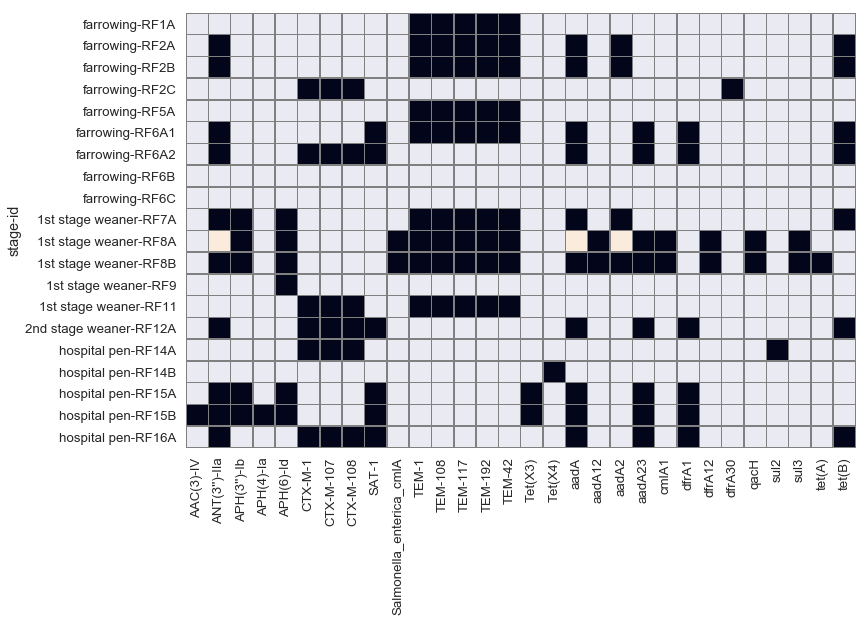

In [408]:
f,ax=plt.subplots(figsize=(12,8))
x = merge_info(m)
sns.heatmap(x[x.columns[:70]],xticklabels=1,linewidths=.5,
             linecolor='gray',cbar=False,ax=ax)

## CTX-M hits

In [ ]:
#translate to protein
seqs = list(SeqIO.parse('ctx.fa','fasta'))
prots=[]
for s in seqs:
    print (s.id)
    p = s.seq.translate(to_stop=True)    
    if len(p)<100:
        p = s.seq[1:].translate(to_stop=True)
    if len(p)<100:
        p = s.seq[2:].translate()
    #print (p)
    prots.append(SeqRecord(p,id=s.id))
SeqIO.write(prots, 'ctx-m_protein.fa','fasta')

In [ ]:
seqs = AlignIO.read('ctx-m_protein.aln','clustal')
aln=AlignIO.MultipleSeqAlignment(seqs)
dm,tree=tools.get_tree(aln)
tools.draw_tree(tree)

## ariba

In [ ]:
for n in pig[2:]:
    print (n)
    f1,f2 = sorted(glob.glob('data/%s*.gz' %n))
    print (f1,f2)
    cmd = 'ariba run card_ariba {f1} {f2} ariba_results/{n}'.format(f1=f1,f2=f2,n=n)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    
'ariba summary ariba_results/*'

In [404]:
tree

Tree(rooted=False)

In [453]:
s=cardseqs['CTX-M-107']
s = s.seq.reverse_complement()
format(s)

'GGTTAAAAAATCACTGCGTCAGTTCACGCTGATGGCGACGGCAACCGTCACGCTGTTGTTAGGAAGTGTGCCGCTGTATGCGCAAACGGCGGACGTACAGCAAAAACTTGCCGAATTAGAGCGGCAGTCGGGAGGCAGACTGGGTGTGGCATTGATTAACACAGCAGATAATTCGCAAATACTTTATCGTGCTGATGAGCGCTTTGCGATGTGCAGCACCAGTAAAGTGATGGCCGCGGCCGCGGTGCTGAAGAAAAGTGAAAGCGAACCGAATCTGTTAAATCAGCGAGTTGAGATCAAAAAATCTGACCTTGTTAACTATAATCCGATTGCGGAAAAGCACGTCAATGGGACGATGTCACTGGCTGAGCTTAGCGCGGCCGCGCTACAGTACAGCGATAACGTGGCGATGAATAAGCTGATTGCTCACGTTGGCGGCCCGGCTAGCGTCACCGCGTTCGCCCGACAGCTGGGAGACGAAACGTTCCGTCTCGACCGTACCGAGCCGACGTTAAACACCGCCATTCCGGGCGATCCGCGTGATACCACTTCACCTCGGGCAATGGCGCAAACTCTGCGGAATCTGACGCTGGGTAAAGCATTGGGCGACAGCCAACGGGCGCAGCTGGTGACATGGATGAAAGGCAATACCACCGGTGCAGCGAGCATTCAGGCTGGACTGCCTGCTTCCTGGGTTGTGGGGGATAGAACCGGCAGCGGTGGCTATGGCACCACCAACGATATCGCGGTGATCTGGCCAAAAGATCGTGCGCCGCTGATTCTGGTCACTTACTTCACCCAGCCTCAACCTAAGGCAGAAAGCCGTCGCGATGTATTAGCGTCGGCGGCTAAAATCGTCACCAA'